# Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
df = pd.read_csv("Merged_Cleansed\OutofSample.csv")
SPY = pd.read_csv("Merged_Cleansed\SPY_test.csv")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df.head(3)

,PERMNO,Date,TICKER,Price,Return,Share Outstanding,Turnover,Dollar Turnover,Current Ratio,Cash Ratio,Quick Ratio,Revenue Growth,COGS Growth,Operating Income Growth,Net Income Growth,EPS Basic Growth,Net Operating Cash Flow Growth
0,10051,2015-12-01,HGR,16.45,0.056519,35291,0.970899,15.971290,1.641972,0.28752,1.32757,0.008599,0.020741,-0.109413,0.940769,-0.590909,0.0
1,10051,2016-01-01,HGR,13.49,-0.179939,35291,1.144994,15.445975,1.641972,0.28752,1.32757,0.008599,0.020741,-0.109413,0.940769,-0.590909,0.0
2,10051,2018-10-01,HNGR,18.66,-0.104177,36799,0.693253,12.936092,1.641972,0.28752,1.32757,0.008599,0.020741,-0.109413,0.940769,-0.590909,0.0


In [4]:
SPY.head(3)

,Date,Return
0,2016-01-01,-0.050735
1,2016-02-01,-0.004128
2,2016-03-01,0.065991


In [5]:
print(df.shape)
print(SPY.shape)

(69651, 17)
(48, 2)


# Explore Correlation

## Liquidity Correlation

In [6]:
df.iloc[:, 6:11].corr()

,Turnover,Dollar Turnover,Current Ratio,Cash Ratio,Quick Ratio
Turnover,1.000000,0.434245,-0.007201,-0.001199,-0.012086
Dollar Turnover,0.434245,1.000000,-0.002034,-0.004193,-0.000462
Current Ratio,-0.007201,-0.002034,1.000000,0.295894,0.906629
Cash Ratio,-0.001199,-0.004193,0.295894,1.000000,0.298606
Quick Ratio,-0.012086,-0.000462,0.906629,0.298606,1.000000


## Growth Correlation

In [7]:
df.iloc[:, 11:].corr()

,Revenue Growth,COGS Growth,Operating Income Growth,Net Income Growth,EPS Basic Growth,Net Operating Cash Flow Growth
Revenue Growth,1.000000,0.024905,-0.002496,-0.002551,-0.001126,-0.000640
COGS Growth,0.024905,1.000000,-0.008474,-0.049512,-0.002983,0.000283
Operating Income Growth,-0.002496,-0.008474,1.000000,-0.002124,-0.000492,0.000584
Net Income Growth,-0.002551,-0.049512,-0.002124,1.000000,0.059696,-0.000273
EPS Basic Growth,-0.001126,-0.002983,-0.000492,0.059696,1.000000,-0.000440
Net Operating Cash Flow Growth,-0.000640,0.000283,0.000584,-0.000273,-0.000440,1.000000


# Run Regression

In [8]:
import statsmodels.api as sm
df_ = df.copy()
df_.dropna(inplace=True)
cols = list(df.columns[6:])
X = df_.copy()[cols]
X = sm.add_constant(X)
y = df_.copy()['Return']

Model = sm.OLS(y, X)
Result = Model.fit()
print(Result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.03
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           1.63e-18
Time:                        10:29:18   Log-Likelihood:                 49757.
No. Observations:               69651   AIC:                        -9.949e+04
Df Residuals:                   69639   BIC:                        -9.938e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

D:\Anaconda\Setup\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


From Regression Table, We can initially know that:
"Dollar Turnover" have significant positive impact on Return

# Rank for factor

## Date Processing

In [9]:
# Transform Date into datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

SPY['Date'] = pd.to_datetime(SPY['Date'])
SPY.set_index('Date', inplace=True)

In [10]:
# Construct Date List
Date = []
for i in range(2016, 2020):
    for j in range(1, 13):
        date = str(i) + '-' + str(j)
        Date.append(date)

## Define Rank Function and Use it to rank for each factor

In [11]:
def percentile_to_score(value):
    if value >= 0.9: value = 1
    elif value >= 0.8: value = 2
    elif value >= 0.7: value = 3
    elif value >= 0.6: value = 4
    elif value >= 0.5: value = 5
    elif value >= 0.4: value = 6
    elif value >= 0.3: value = 7
    elif value >= 0.2: value = 8
    elif value >= 0.1: value = 9
    elif value >= 0.0: value = 10
    return value 

def Rank(df_, factor, factor_rank, Date):
    df = df_.copy()
        
    # First, we select the first date's dataframe and rank
    dataframe = df[Date[0]].copy()
#     dataframe = dataframe.sort_values(by = [factor], axis = 0, ascending = False)  # Sort by Turnover
#     dataframe[factor_rank] = range(len(dataframe))  
#     dataframe[factor_rank] += 1 
    dataframe[factor_rank] = dataframe[factor].rank(pct=True).apply(lambda x: percentile_to_score(x))
    
    for i in range(1, len(Date)):
        DF = df[Date[i]].copy()  # Divide the big df into small DF by date
#         DF = DF.sort_values(by = [factor], axis = 0, ascending = False)  # Sort by Turnover
#         DF[factor_rank] = range(len(DF))  
#         DF[factor_rank] += 1 
        DF[factor_rank] = DF[factor].rank(pct=True).apply(lambda x: percentile_to_score(x))
        dataframe = pd.concat([dataframe, DF])
    
    return dataframe

In [12]:
Factor_List = list(df.columns[5:])
Factor_Rank = []

for factor in Factor_List:
    factor_rank = factor + " Rank"
    Factor_Rank.append(factor_rank)
    df = Rank(df, factor, factor_rank, Date)   # Rank for each factor

In [13]:
df.head(3)

,PERMNO,TICKER,Price,Return,Share Outstanding,Turnover,Dollar Turnover,Current Ratio,Cash Ratio,Quick Ratio,Revenue Growth,COGS Growth,Operating Income Growth,Net Income Growth,EPS Basic Growth,Net Operating Cash Flow Growth,Turnover Rank,Dollar Turnover Rank,Current Ratio Rank,Cash Ratio Rank,Quick Ratio Rank,Revenue Growth Rank,COGS Growth Rank,Operating Income Growth Rank,Net Income Growth Rank,EPS Basic Growth Rank,Net Operating Cash Flow Growth Rank
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,10051,HGR,13.49,-0.179939,35291,1.144994,15.445975,1.641972,0.287520,1.327570,0.008599,0.020741,-0.109413,0.940769,-0.590909,0.000000,8,8,5,6,5,5,4,8,2,8,9
2016-01-01,10145,HON,103.20,-0.003572,770691,0.934442,96.434409,1.091557,0.296935,0.850961,-0.016777,-0.026251,0.015911,0.058626,0.065789,0.910880,9,3,8,6,8,6,7,5,4,4,3
2016-01-01,10147,EMC,24.77,-0.035436,1943000,1.660859,41.139490,1.169034,0.719829,1.072410,0.000988,-0.022773,-0.009288,-0.014374,0.000000,0.663985,6,6,8,4,6,5,7,6,5,5,4


In [23]:
df.to_csv("OutofSample_Fast.csv", index=False)

In [14]:
#df_ = df.copy()
for factor in Factor_List:
    #del df_[factor]
    del df[factor]
    
df.head(3)

,PERMNO,TICKER,Price,Return,Share Outstanding,Turnover Rank,Dollar Turnover Rank,Current Ratio Rank,Cash Ratio Rank,Quick Ratio Rank,Revenue Growth Rank,COGS Growth Rank,Operating Income Growth Rank,Net Income Growth Rank,EPS Basic Growth Rank,Net Operating Cash Flow Growth Rank
Date,,,,,,,,,,,,,,,,
2016-01-01,10051,HGR,13.49,-0.179939,35291,8,8,5,6,5,5,4,8,2,8,9
2016-01-01,10145,HON,103.20,-0.003572,770691,9,3,8,6,8,6,7,5,4,4,3
2016-01-01,10147,EMC,24.77,-0.035436,1943000,6,6,8,4,6,5,7,6,5,5,4


# Select Stocks based on Rank

In [15]:
# class Solve():
#     def __init__(self, df, SPY, Date, Factor_Rank):
#         self.df = df
#         self.SPY = SPY
#         self.Date = Date
#         self.Factor_Rank = Factor_Rank
               
#     def Get_Returns(self):
#         self.df_ = self.df.copy()
#         self.Returns = {} # Used to store each factor's return for each month
#         self.Excesses = {} # Used to store each factor's return for each excess month
           
#         for factor in self.Factor_Rank:
#             Return = []  # Used to store return for each month
#             Excess = []  # Used to store excess return for each month
#             for date in Date:
#                 DF = self.df_[date].copy()  # Divide the big df into small DF by date
#                 N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
#                 DF = DF.sort_values(by = [factor], axis = 0, ascending = True)  # Sort by Turnover
#                 #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
#                 profit = DF.iloc[int(0.1*N):int(1.1*N)]['Return'].mean()
#                 #profit = DF.iloc[-N:]['Return'].mean()
#                 profit_SPY = self.SPY[date]['Return'].values[0]

#                 Return.append( profit )
#                 Excess.append( profit - profit_SPY )

#             self.Returns[factor] = Return 
#             self.Excesses[factor] = Excess

#     def Return_Summary(self):
#         print("Summary for SPY Return:"); print(self.SPY['Return'].describe())
#         print("=============++++++++++++++=============")
        
#         for key in self.Factor_Rank:
#             print("=============" + key + "=============")
#             print("Summary for Return:"); print(pd.Series(self.Returns[key]).describe(), "\n")
#             print("Summary for Excess Return:"); print(pd.Series(self.Excesses[key]).describe())
#             print("=============++++++++++++++=============")
        
#     def T_Test(self):
#         from scipy import stats
#         print("==============================++++++++++++++==============================")
#         for factor in self.Factor_Rank:
#             print("Result of T Test for " + factor + ":")
#             print(stats.ttest_1samp(self.Excesses[factor], 0))
#             print("==============================++++++++++++++==============================")
            
#     def Plot_hist_Return(self):
#         plt.figure(figsize=(15,3))
#         count = 0
        
#         for key in self.Factor_Rank:
#             count += 1
#             ax = plt.subplot(13,2,count)
#             plt.hist(self.Returns[key], bins=8)
#             plt.ylabel('Frequency')
#             plt.title('Distribution of Return from' + key)
            
#             count += 1
#             ax = plt.subplot(13,2,count)
#             plt.hist(self.Excesses[key], bins=20)
#             plt.ylabel('Frequency')
#             plt.title('Distribution of Excess Return from' + key)


#     def Plot_Cum_Return(self):
#         fig1 = plt.figure(figsize = (16, 6))
#         ax1 = fig1.add_subplot(111)
        
#         plt.plot(self.Date, (self.SPY['Return'] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
#         for factor in self.Factor_Rank:
#             plt.plot(self.Date, (pd.Series(self.Returns[factor])+1).cumprod()-1, label = factor) 
            
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Returns for each Factor',fontsize =15)
        
#         colormap = plt.cm.gist_ncar
#         colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
#         for i,j in enumerate(ax1.lines):
#             j.set_color(colors[i])
#         ax1.legend(loc=2)
        
#     def Plot_Cum_Excess(self):
#         fig1 = plt.figure(figsize = (16, 6))
#         ax1 = fig1.add_subplot(111)
        
#         plt.plot(self.Date, (self.SPY['Return'] + 1).cumprod()-1, label = 'SPY', color = 'black') 

#         for factor in self.Factor_Rank:
#             plt.plot(self.Date, (pd.Series(self.Excesses[factor])+1).cumprod()-1, label = factor) 
 
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Excess Returns for each Factor',fontsize =15)

#         colormap = plt.cm.gist_ncar
#         colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]

#         for i,j in enumerate(ax1.lines):
#             j.set_color(colors[i])
#         ax1.legend(loc=2)

In [16]:
class Solve():
    def __init__(self, df, SPY, Date, Factor_Rank):
        self.df = df
        self.SPY = SPY
        self.Date = Date
        self.Factor_Rank = Factor_Rank
               
    def Get_Returns(self):
        self.df_ = self.df.copy()
        self.Returns1 = {} # Used to store TOP each factor's return for each month
        self.Returns2 = {} # Used to store BOT each factor's return for each month
        self.Excesses1 = {} # Used to store TOP each factor's excess return for each month
        self.Excesses2 = {} # Used to store BOT each factor's excess return for each month
        self.Diffs = {} # Used to store each factor's diff return for each month
        self.Diffs_Excess = {} # Used to store each factor's diff excess return for each month
           
        for factor in self.Factor_Rank:
            Return1 = []  # Used to store TOP return for each month
            Return2 = []  # Used to store BOT return for each month
            Excess1 = []  # Used to store TOP excess return for each month
            Excess2 = []  # Used to store BOT excess return for each month
            Diff = []    # Used to store return of difference between TOP and BOT for each month
            Diff_Excess = []    # Used to store excess return of difference between TOP and BOT for each month
            for date in Date:
                DF = self.df_[date].copy()  # Divide the big df into small DF by date
                N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
                DF = DF.sort_values(by = [factor], axis = 0, ascending = True)  # Sort by Turnover
                #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
                profit1 = DF.iloc[:N]['Return'].mean()
                profit2 = DF.iloc[-N:]['Return'].mean()
                diff = profit1 - profit2
                profit_SPY = self.SPY[date]['Return'].values[0]

                Return1.append( profit1 )
                Return2.append( profit2 )
                Excess1.append( profit1 - profit_SPY )
                Excess2.append( profit2 - profit_SPY )
                Diff.append( diff )
                Diff_Excess.append( diff - profit_SPY )

            self.Returns1[factor] = Return1 
            self.Returns2[factor] = Return2 
            self.Excesses1[factor] = Excess1
            self.Excesses2[factor] = Excess2
            self.Diffs[factor] = Diff
            self.Diffs_Excess[factor] = Diff_Excess

    def Return_Summary(self):
        print("Summary for SPY Return:"); print(self.SPY['Return'].describe())
        print("=============++++++++++++++=============")
        
        for key in self.Factor_Rank:
            print("=================" + key + "=================")
            print("Summary for TOP Return:"); print(pd.Series(self.Returns1[key]).describe(), "\n")
            print("Summary for BOT Return:"); print(pd.Series(self.Returns2[key]).describe(), "\n")
            print("Summary for Diff Return:"); print(pd.Series(self.Diffs[key]).describe(), "\n")
            print("Summary for TOP Excess Return:"); print(pd.Series(self.Excesses1[key]).describe(), "\n")
            print("Summary for BOT Excess Return:"); print(pd.Series(self.Excesses2[key]).describe(), "\n")
            print("Summary for Diff Excess Return:"); print(pd.Series(self.Diffs_Excess[key]).describe())
            print("=================++++++++++++++=================")
        
    def T_Test_Return(self):
        from scipy import stats
        print("==============================T Test For Return==============================")
        for factor in self.Factor_Rank:
            print("Result of T Test for " + factor + "(TOP):")
            print(stats.ttest_1samp(self.Returns1[factor], 0))
            print("Result of T Test for " + factor + "(BOT):")
            print(stats.ttest_1samp(self.Returns2[factor], 0))
            print("Result of T Test for " + factor + "(Diff):")
            print(stats.ttest_1samp(self.Diffs[factor], 0))
            print("==============================++++++++++++++==============================")
            
    def T_Test_Excess(self):
        from scipy import stats
        print("==============================T Test For Excess Return==============================")
        for factor in self.Factor_Rank:
            print("Result of T Test for " + factor + "(TOP):")
            print(stats.ttest_1samp(self.Excesses1[factor], 0))
            print("Result of T Test for " + factor + "(BOT):")
            print(stats.ttest_1samp(self.Excesses2[factor], 0))
            print("Result of T Test for " + factor + "(Diff Excess):")
            print(stats.ttest_1samp(self.Diffs_Excess[factor], 0))
            print("==============================++++++++++++++==============================")
            
    def Plot_hist_Return(self):
        plt.figure(figsize=(15,3))
        count = 0
        
        for key in self.Factor_Rank:
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Returns1[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of TOP Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Excesses1[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of TOP Excess Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Returns2[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of BOT Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Excesses2[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of BOT Excess Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Diffs[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of Diff Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Diffs_Excess[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of Diff Excess Return from' + key)


    def Plot_Cum_TOP_Return(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Returns1[factor])+1).cumprod()-1, label = factor) 
            
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Returns for each Factor (TOP)',fontsize =15)
        
        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_TOP_Excess(self):

        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black') 

        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Excesses1[factor])+1).cumprod()-1, label = factor) 
 
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Excess Returns for each Factor (TOP)',fontsize =15)

        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]

        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_BOT_Return(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Returns2[factor])+1).cumprod()-1, label = factor) 
            
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Returns for each Factor (BOT)',fontsize =15)
        
        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_BOT_Excess(self):

        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black') 

        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Excesses2[factor])+1).cumprod()-1, label = factor) 
 
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Excess Returns for each Factor (BOT)',fontsize =15)

        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]

        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_Diff_Return(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Diffs[factor])+1).cumprod()-1, label = factor) 
            
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Returns for each Factor (BOT)',fontsize =15)
        
        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_Diff_Excess(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black') 

        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Diffs_Excess[factor])+1).cumprod()-1, label = factor) 
 
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Excess Returns for each Factor (Diff)',fontsize =15)

        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]

        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)

In [17]:
Object = Solve(df, SPY, Date, Factor_Rank)

## Calculate Returns and Excess Returns

In [18]:
Object.Get_Returns()

## Give a Summary for all Factors' Return and Excess

In [19]:
Object.Return_Summary()

Summary for SPY Return:
count    48.000000
mean      0.010139
std       0.033477
min      -0.091777
25%       0.000313
50%       0.016253
75%       0.029862
max       0.078684
Name: Return, dtype: float64
=============++++++++++++++=============
=================Turnover Rank=================
Summary for TOP Return:
count    48.000000
mean      0.013394
std       0.078451
min      -0.150279
25%      -0.033990
50%       0.012127
75%       0.057014
max       0.208842
dtype: float64 

Summary for BOT Return:
count    48.000000
mean      0.004193
std       0.038018
min      -0.095375
25%      -0.011801
50%       0.009859
75%       0.021699
max       0.107357
dtype: float64 

Summary for Diff Return:
count    48.000000
mean      0.009201
std       0.047822
min      -0.076135
25%      -0.020074
50%       0.006847
75%       0.039950
max       0.125156
dtype: float64 

Summary for TOP Excess Return:
count    48.000000
mean      0.003255
std       0.058733
min      -0.092318
25%      -0.043488


In [20]:
Object.T_Test_Return()

==============================T Test For Return==============================
Result of T Test for Turnover Rank(TOP):
Ttest_1sampResult(statistic=1.1828291220947176, pvalue=0.2428259003341523)
Result of T Test for Turnover Rank(BOT):
Ttest_1sampResult(statistic=0.7641048418598405, pvalue=0.4486239757645367)
Result of T Test for Turnover Rank(Diff):
Ttest_1sampResult(statistic=1.3329584224937479, pvalue=0.18897116659751395)
==============================++++++++++++++==============================
Result of T Test for Dollar Turnover Rank(TOP):
Ttest_1sampResult(statistic=3.812816830023736, pvalue=0.0003992902321426063)
Result of T Test for Dollar Turnover Rank(BOT):
Ttest_1sampResult(statistic=-0.6308886513216373, pvalue=0.5311694318964715)
Result of T Test for Dollar Turnover Rank(Diff):
Ttest_1sampResult(statistic=6.648817405561922, pvalue=2.789556559090509e-08)
==============================++++++++++++++==============================
Result of T Test for Current Ratio Rank(TOP):
T

In [21]:
Object.T_Test_Excess()

==============================T Test For Excess Return==============================
Result of T Test for Turnover Rank(TOP):
Ttest_1sampResult(statistic=0.3839602833977121, pvalue=0.7027394905782698)
Result of T Test for Turnover Rank(BOT):
Ttest_1sampResult(statistic=-1.9765105147738573, pvalue=0.05398166667586477)
Result of T Test for Turnover Rank(Diff Excess):
Ttest_1sampResult(statistic=-0.15697676169816255, pvalue=0.8759355691301434)
==============================++++++++++++++==============================
Result of T Test for Dollar Turnover Rank(TOP):
Ttest_1sampResult(statistic=4.821210449087506, pvalue=1.535604721908385e-05)
Result of T Test for Dollar Turnover Rank(BOT):
Ttest_1sampResult(statistic=-2.7632092178396133, pvalue=0.008145804520046724)
Result of T Test for Dollar Turnover Rank(Diff Excess):
Ttest_1sampResult(statistic=2.979268616046394, pvalue=0.004561286919233936)
==============================++++++++++++++==============================
Result of T Test for C

## Plot Cumulative Return for each Factor

ValueError: x and y must have same first dimension, but have shapes (48,) and (47,)

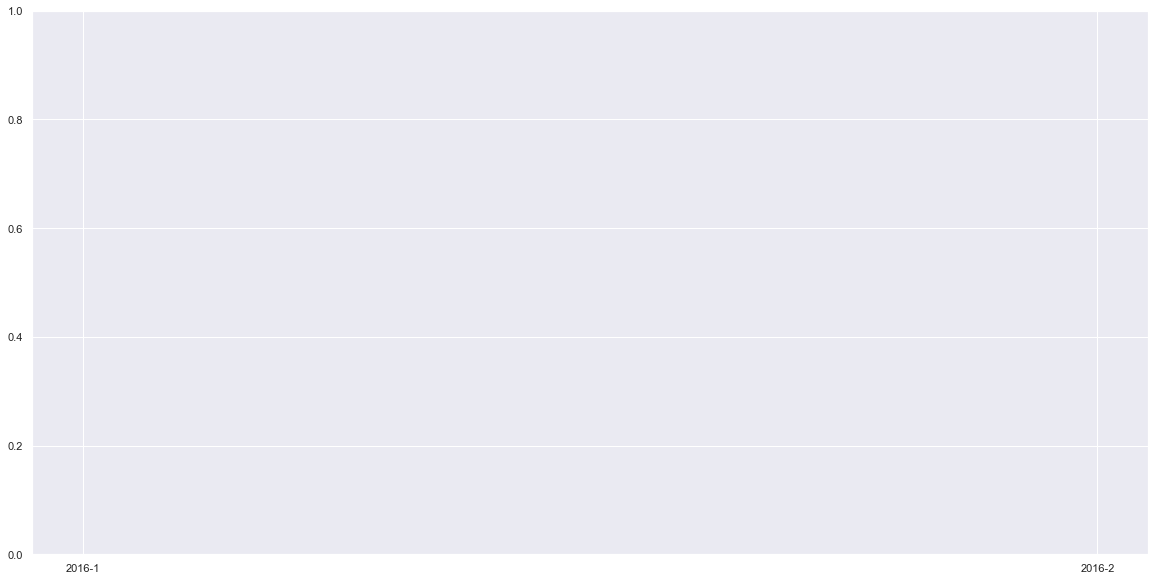

In [22]:
Object.Plot_Cum_TOP_Return()

In [ ]:
Object.Plot_Cum_BOT_Return()

In [ ]:
Object.Plot_Cum_TOP_Excess()

In [ ]:
Object.Plot_Cum_BOT_Excess()

In [ ]:
Object.Plot_Cum_Diff_Return()

In [ ]:
Object.Plot_Cum_Diff_Excess()

# Combine Factors

In [ ]:
# class Combine():
#     def __init__(self, df, SPY, Date):
#         self.df = df
#         self.SPY = SPY
#         self.Date = Date
        
#     def Combine_Factors(self):
#         self.data = self.df.copy()
# #         self.data['Liquid Ratio Rank'] = (self.data['Cash Ratio Rank'] + self.data['Current Ratio Rank'] + self.data['Quick Ratio Rank']) / 3 
# #         self.data['Turnover Combine Rank'] = (self.data['Turnover Rank'] + self.data['Dollar Turnover Rank']) / 2
# #         self.data['Income Combine Rank'] = (self.data['COGS Growth Rank'] + self.data['Operating Income Growth Rank'] + self.data['Net Income Growth Rank']) / 3
        
# #         self.data['Total Rank'] = (self.data['Dollar Turnover Rank'] + self.data['Operating Income Growth Rank'] +
# #                                    self.data['EPS Basic Growth Rank'] + self.data['Net Operating Cash Flow Growth Rank'] +
# #                                    self.data['Net Income Growth Rank']) / 6
#         self.data['Liquid Ratio Rank'] = (self.data['Cash Ratio Rank'] + self.data['Current Ratio Rank'] + self.data['Quick Ratio Rank']) / 3 
#         self.data['Turnover Combine Rank'] = (self.data['Turnover Rank'] + self.data['Dollar Turnover Rank']) / 2
#         self.data['Income Combine Rank'] = (self.data['COGS Growth Rank'] + self.data['Operating Income Growth Rank'] + self.data['Net Income Growth Rank']) / 3
        
#         self.data['Total Rank'] = (self.data['Revenue Growth Rank'] + self.data['Income Combine Rank'] +
#                                    self.data['EPS Basic Growth Rank'] + self.data['Net Operating Cash Flow Growth Rank'] + self.data['Liquid Ratio Rank'] +
#                                    self.data['Income Combine Rank']) / 6
               
#     def Get_Returns(self):
#         self.data_ = self.data.copy()
           
#         self.Return = []  # Used to store return for each month
#         self.Excess = []  # Used to store excess return for each month
#         for date in Date:
#             DF = self.data_[date].copy()  # Divide the big df into small DF by date
#             N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
#             DF = DF.sort_values(by = ['Total Rank'], axis = 0, ascending = True)  # Sort by Turnover
#             #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
#             profit = DF.iloc[int(0.1*N):int(1.1*N)]['Return'].mean()
#             #profit = DF.iloc[-N:]['Return'].mean()
#             profit_SPY = self.SPY[date]['Return'].values[0]

#             self.Return.append( profit )
#             self.Excess.append( profit - profit_SPY )

#     def Return_Summary(self):
#         print("=============++++++++++++++=============")
#         print("Summary for SPY Return:"); print(self.SPY['Return'].describe())
#         print("=============++++++++++++++=============")
#         print("Summary for Return:")
#         print(pd.Series(self.Return).describe())
#         print("=============++++++++++++++=============")
#         print("Summary for Excess Return:")
#         print(pd.Series(self.Excess).describe())
#         print("=============++++++++++++++=============")
        
#     def T_Test(self):
#         from scipy import stats
#         print("==============================++++++++++++++==============================")
#         print("Result of T Test")
#         print(stats.ttest_1samp(self.Excess, 0))
#         print("==============================++++++++++++++==============================")
            
#     def Plot_hist_Return(self):
#         plt.figure(figsize=(12,4))
#         ax1 = plt.subplot(1,3,1)
#         plt.hist(self.Return, bins=5)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of Return')
            
#         ax2 = plt.subplot(1,3,2)
#         plt.hist(self.Excess, bins=5)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of Excess Return') 
        
#         ax3 = plt.subplot(1,3,3)
#         plt.hist(self.SPY['Return'].values, bins=5)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of SPY Return') 

#     def Plot_Cum_Return(self):
#         fig1 = plt.figure(figsize = (12, 4))
#         ax1 = fig1.add_subplot(111)
        
#         plt.plot(self.Date, (self.SPY['Return'] + 1).cumprod()-1, label = 'SPY Return')
        
#         plt.plot(self.Date, (pd.Series(self.Return)+1).cumprod()-1, label = 'Return')   
#         plt.plot(self.Date, (pd.Series(self.Excess)+1).cumprod()-1, label = 'Excess Return') 
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Return for Combine Factor',fontsize =15)
        
#         ax1.legend(loc=2)

In [ ]:
class Combine():
    def __init__(self, df, SPY, Date):
        self.df = df
        self.SPY = SPY
        self.Date = Date
        
    def Combine_Factors(self):
        self.data = self.df.copy()
        self.data['Liquid Ratio Rank'] = (self.data['Cash Ratio Rank'] + self.data['Current Ratio Rank'] + self.data['Quick Ratio Rank']) / 3 
        self.data['Turnover Combine Rank'] = (self.data['Turnover Rank'] + self.data['Dollar Turnover Rank']) / 2
        self.data['Income Combine Rank'] = (self.data['COGS Growth Rank'] + self.data['Operating Income Growth Rank'] + self.data['Net Income Growth Rank']) / 3
        
        self.data['Total Rank'] = (self.data['Revenue Growth Rank'] + self.data['Income Combine Rank'] +
                                   self.data['EPS Basic Growth Rank'] + self.data['Net Operating Cash Flow Growth Rank'] + self.data['Liquid Ratio Rank'] +
                                   self.data['Income Combine Rank']) / 6
               
    def Get_Returns(self):
        self.data_ = self.data.copy()
           
        self.Return1 = []  # Used to store TOP return for each month
        self.Excess1 = []  # Used to store TOP excess return for each month
        self.Return2 = []  # Used to store BOT return for each month
        self.Excess2 = []  # Used to store BOT excess return for each month
        self.Diff = []  # Used to store diff return for each month
        self.Diff_Excess = []  # Used to store diff excess return for each month
        for date in Date:
            DF = self.data_[date].copy()  # Divide the big df into small DF by date
            N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
            DF = DF.sort_values(by = ['Total Rank'], axis = 0, ascending = True)  # Sort by Turnover
            #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
            profit1 = DF.iloc[N]['Return'].mean()
            profit2 = DF.iloc[-N:]['Return'].mean()
            profit_SPY = self.SPY[date]['Return'].values[0]
            diff = profit1 - profit2

            self.Return1.append( profit1 )
            self.Excess1.append( profit1 - profit_SPY )
            self.Return2.append( profit2 )
            self.Excess2.append( profit2 - profit_SPY )
            self.Diff.append( diff )
            self.Diff_Excess.append( diff - profit_SPY )

    def Return_Summary(self):
        print("=============++++++++++++++=============")
        print("Summary for SPY Return:"); print(self.SPY['Return'].describe())
        print("=============++++++++++++++=============")
        print("Summary for Return(TOP):")
        print(pd.Series(self.Return1).describe())
        print("=============++++++++++++++=============")
        print("Summary for Excess Return(TOP):")
        print(pd.Series(self.Excess1).describe())
        print("=============++++++++++++++=============")
        print("Summary for Return(BOT):")
        print(pd.Series(self.Return2).describe())
        print("=============++++++++++++++=============")
        print("Summary for Excess Return(BOT):")
        print(pd.Series(self.Excess2).describe())
        print("=============++++++++++++++=============")
        print("Summary for Return(Diff):")
        print(pd.Series(self.Diff).describe())
        print("=============++++++++++++++=============")
        print("Summary for Excess Return(Diff):")
        print(pd.Series(self.Diff_Excess).describe())
        print("=============++++++++++++++=============")
        
    def T_Test(self):
        from scipy import stats
        print("==============================++++++++++++++==============================")
        print("Result of T Test (TOP)")
        print(stats.ttest_1samp(self.Excess1, 0))
        print("Result of T Test (BOT)")
        print(stats.ttest_1samp(self.Excess2, 0))
        print("Result of T Test (Diff)")
        print(stats.ttest_1samp(self.Diff, 0))
        print("Result of T Test (Diff Excess)")
        print(stats.ttest_1samp(self.Diff_Excess, 0))
        print("==============================++++++++++++++==============================")
            
    def Plot_hist_Return(self):
        plt.figure(figsize=(30,4))
        
        ax1 = plt.subplot(1,7,1)
        plt.hist(self.SPY['Return'].values, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of SPY Return') 
        
        ax2 = plt.subplot(1,7,2)
        plt.hist(self.Return1, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of TOP Return')
            
        ax3 = plt.subplot(1,7,3)
        plt.hist(self.Excess1, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of TOP Excess Return') 
        
        ax4 = plt.subplot(1,7,4)
        plt.hist(self.Return2, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of BOT Return')
            
        ax5 = plt.subplot(1,7,5)
        plt.hist(self.Excess2, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of BOT Excess Return') 
        
        ax6 = plt.subplot(1,7,6)
        plt.hist(self.Diff, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of Diff Return')
            
        ax7 = plt.subplot(1,7,7)
        plt.hist(self.Diff_Excess, bins=20)
        plt.ylabel('Frequency')
        plt.title('Distribution of Diff Excess Return') 

    def Plot_Cum_Return(self):
        fig1 = plt.figure(figsize = (15, 6))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY Return')
        
        plt.plot(self.Date, (pd.Series(self.Return1)+1).cumprod()-1, label = 'TOP Return')   
        #plt.plot(self.Date, (pd.Series(self.Excess1)+1).cumprod()-1, label = 'TOP Excess Return') 
        plt.plot(self.Date, (pd.Series(self.Return2)+1).cumprod()-1, label = 'BOT Return')   
        #plt.plot(self.Date, (pd.Series(self.Excess2)+1).cumprod()-1, label = 'BOT Excess Return')
        plt.plot(self.Date, (pd.Series(self.Diff)+1).cumprod()-1, label = 'Diff Return')   
        #plt.plot(self.Date, (pd.Series(self.Diff_Excess)+1).cumprod()-1, label = 'Diff Excess Return') 
        
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Return for Combine Factor',fontsize =15)
        
        ax1.legend(loc=2)
        
    def Plot_Cum_Excess(self):
        fig1 = plt.figure(figsize = (15, 6))
        ax1 = fig1.add_subplot(111)
        
        #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY Return')
        
        #plt.plot(self.Date, (pd.Series(self.Return1)+1).cumprod()-1, label = 'TOP Return')   
        plt.plot(self.Date, (pd.Series(self.Excess1)+1).cumprod()-1, label = 'TOP Excess Return') 
        #plt.plot(self.Date, (pd.Series(self.Return2)+1).cumprod()-1, label = 'BOT Return')   
        plt.plot(self.Date, (pd.Series(self.Excess2)+1).cumprod()-1, label = 'BOT Excess Return')
        #plt.plot(self.Date, (pd.Series(self.Diff)+1).cumprod()-1, label = 'Diff Return')   
        plt.plot(self.Date, (pd.Series(self.Diff_Excess)+1).cumprod()-1, label = 'Diff Excess Return') 
        
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Excess Return for Combine Factor',fontsize =15)
        
        ax1.legend(loc=2)

In [ ]:
Object2 = Combine(df, SPY, Date)

## Combine All these Factors into one

In [ ]:
Object2.Combine_Factors()

## Calculate Return

In [ ]:
Object2.Get_Returns()

## Give a Summary for Return and T Test for Excess Return

In [ ]:
Object2.Return_Summary()

In [ ]:
Object2.T_Test()

## Plot Cumulative Return

In [ ]:
Object2.Plot_hist_Return()

In [ ]:
Object2.Plot_Cum_Return()

In [ ]:
Object2.Plot_Cum_Excess()

# Calculate Indicators

In [ ]:
Return_TOP = Object.Returns1
Return_BOT = Object.Returns2
Return_Diff = Object.Diffs

Excess_TOP = Object.Excesses1
Excess_BOT = Object.Excesses2
Excess_Diff = Object.Diffs_Excess

Rm = Object.SPY.iloc[1:].values.ravel()

Rf = 0.0161 / 12   # 5-Year Risk-Free Rate from Jan. 2015, /12 -> Monthly Return

## Calculate Alpha & Beta

In [ ]:
class Indicators():
    def __init__(self, Return_TOP, Return_BOT, Return_Diff, Rm, Rf, Factor_Rank):
        self.Return_TOP = Return_TOP
        self.Return_BOT = Return_BOT
        self.Return_DIF = Return_Diff
#         self.Excess_TOP = Excess_TOP
#         self.Excess_BOT = Excess_BOT
#         self.Excess_Diff = Excess_Diff
        self.Rm = Rm
        self.Rf = Rf
#         self.Date = Date
        self.Factor_Rank = Factor_Rank
        
    def Cal_Beta(self):
        self.Beta_TOP = {}
        self.Beta_BOT = {}
        self.Beta_DIF = {}
        Variance_Rm = np.var(self.Rm)
        
        for key in self.Factor_Rank:
            self.Beta_TOP[key] = np.cov(self.Return_TOP[key], self.Rm)[0,1]
            self.Beta_BOT[key] = np.cov(self.Return_BOT[key], self.Rm)[0,1]
            self.Beta_DIF[key] = np.cov(self.Return_DIF[key], self.Rm)[0,1]
        
    def Cal_Alpha(self):        
        self.Alpha_TOP = {}
        self.Alpha_BOT = {}
        self.Alpha_DIF = {}
        
        for key in self.Factor_Rank:
            self.R_TOP = []; self.E_TOP = []
            self.R_BOT = []; self.E_BOT = []
            self.R_DIF = []; self.E_DIF = []
            for i in range(251):
                self.R_TOP.append(self.Return_TOP[key][i] - self.Rf - self.Beta_TOP[key] * (self.Rm[i] - self.Rf))
                self.R_BOT.append(self.Return_BOT[key][i] - self.Rf - self.Beta_BOT[key] * (self.Rm[i] - self.Rf))
                self.R_DIF.append(self.Return_DIF[key][i] - self.Rf - self.Beta_DIF[key] * (self.Rm[i] - self.Rf))
                
            self.Alpha_TOP[key] = self.R_TOP
            self.Alpha_BOT[key] = self.R_BOT
            self.Alpha_DIF[key] = self.R_DIF
            
    def Summary_Alpha(self):
        from scipy import stats
        for key in self.Factor_Rank:  
            print("============================" + key + "============================")
            print("Mean of " + key + "'s Alpha (TOP): ", np.mean(self.Alpha_TOP[key]))
            print("Result of T Test for " + key + "'s Alpha is(TOP): ")
            print(stats.ttest_1samp(self.Alpha_TOP[key], 0), "\n")
            
            print("Mean of " + key + "'s Alpha (BOT): ", np.mean(self.Alpha_BOT[key]))
            print("Result of T Test for " + key + "'s Alpha is(BOT): ")
            print(stats.ttest_1samp(self.Alpha_BOT[key], 0), "\n")
            
            print("Mean of " + key + "'s Alpha (DIF): ", np.mean(self.Alpha_DIF[key]))
            print("Result of T Test for " + key + "'s Alpha is(DIF): ")
            print(stats.ttest_1samp(self.Alpha_DIF[key], 0), "\n")    
            
        
        print("============================++++++++++++++============================")

In [ ]:
Object3 = Indicators(Return_TOP, Return_BOT, Return_Diff, Rm, Rf, Factor_Rank)

In [ ]:
Object3.Cal_Beta()
Object3.Cal_Alpha()

In [ ]:
Object3.Summary_Alpha()